In [1]:
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import uproot
import utils
import yaml
from tensorflow import keras
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

2023-03-24 09:38:58.059347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 09:38:58.216192: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 09:38:59.833586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/pkgs/cudnn-8.1.0.77-h90431f1_0/lib/:/opt/conda/pkgs/cudatoolkit-11.2.2-he111

In [2]:
torch.cuda.empty_cache()

### Preprocessing

In [3]:
with open('definitions_image.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

In [5]:
labels

['label_QCD_b',
 'label_QCD_bb',
 'label_QCD_c',
 'label_QCD_cc',
 'label_QCD_others',
 'sample_isQCD',
 'label_H_bb']

In [6]:
# convert to torch
def keras_to_torch(X, y):
    X_torch = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_torch = torch.tensor(y, dtype=torch.long)
    return X_torch, y_torch

In [7]:
#load training file
feature_array, y, spec_array = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root', 
                                                         features, 
                                                         spectators, 
                                                         labels, 
                                                         remove_mass_pt_window=False, 
                                                         entry_stop=20000)

In [8]:
y = y[:,1]

In [9]:
train_background = 0
for temp in y:
    if temp == 0:
        train_background +=1
print(f"The portion of background data in the training dataset is {train_background / len(y)}"  )

The portion of background data in the training dataset is 0.8678893213200405


In [10]:
ratio = 0.2
feature_resampled = []
y_resampled = []
for i in range(y.shape[0]):
    if y[i] == 0:
        if np.random.random() < ratio:
            feature_resampled.append(feature_array[i])
            y_resampled.append(y[i])
    else:
        feature_resampled.append(feature_array[i])
        y_resampled.append(y[i])

# Convert the lists to NumPy arrays
feature_resampled = np.array(feature_resampled)
y_resampled = np.array(y_resampled)

In [11]:
train_background_resampled = 0
for temp in y_resampled:
    if temp == 0:
        train_background_resampled +=1
print(f"The portion of background data in the resampled training dataset is {train_background_resampled / len(y_resampled)}"  )

The portion of background data in the resampled training dataset is 0.5717988595127009


In [12]:
# make image
X = utils.make_image(feature_resampled)
# image is a 4D tensor (n_samples, n_pixels_x, n_pixels_y, n_channels)
X_train, y_train = keras_to_torch(X, y_resampled)

In [13]:
# load testing file
feature_array_test, label_array_test, spec_array_test = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root', 
                                                                                  features, 
                                                                                  spectators, 
                                                                                  labels, 
                                                                                  remove_mass_pt_window=False, 
                                                                                  entry_stop=2500)


In [14]:
# make image
X_test = utils.make_image(feature_array_test)
X_test, y_test = keras_to_torch(X_test, label_array_test)

In [15]:
y_test = y_test[:,1]
y_test

tensor([0, 0, 1,  ..., 0, 0, 0])

### Model

In [16]:
def conv_output_size(input_size, kernel_size, stride, padding):
    return (input_size - kernel_size + 2 * padding) // stride + 1

In [17]:
# TODO: check numbers in arguments
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        
        print(input_shape)
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception modules
        self.inc1 = Inception_Module(64, 'inc1')
        self.inc2 = Inception_Module(256, 'inc2')
        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # More inception modules
        self.inc3 = Inception_Module(256, 'inc3')
        
        self.pool4 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)  # Adjust the input size according to the output of the previous layer

    def forward(self, x):
        x = self.conv1(x)
        #x = self.relu1(x)
        x = self.pool1(x)
        x = self.lrn1(x)

        x = self.conv2(x)
        #x = self.relu2(x)

        x = self.conv3(x)
        #x = self.relu3(x)
        x = self.lrn2(x)
        x = self.pool2(x)

        # Inception modules
        x = self.inc1(x)
        x = self.inc2(x)

        x = self.pool3(x)

        # More inception modules
        x = self.inc3(x)

        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

In [18]:
class Inception_Module(nn.Module):
    def __init__(self, in_channels, name):
        super(Inception_Module, self).__init__()
        
        self.conv_a1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_a1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_b1 = nn.Conv2d(in_channels, 96, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_b1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_c1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.pool_d1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.conv_b2 = nn.Conv2d(96, 128, kernel_size=3, padding=1)
        self.conv_c2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv_d2 = nn.Conv2d(in_channels, 32, kernel_size=1)

    def forward(self, x):
        a1 = F.relu(self.conv_a1(x))
        b1 = F.relu(self.conv_b1(x))
        c1 = F.relu(self.conv_c1(x))
        d1 = F.relu(self.pool_d1(x))
        
        b2 = F.relu(self.conv_b2(b1))
        c2 = F.relu(self.conv_c2(c1))
        d2 = F.relu(self.conv_d2(d1))

        output = torch.cat((a1, b2, c2, d2), dim=1)
        return output

In [19]:
class Inception_Module(nn.Module):
    def __init__(self, in_channels, name):
        super(Inception_Module, self).__init__()
        
        self.conv_a1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_a1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_b1 = nn.Conv2d(in_channels, 96, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_b1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_c1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.pool_d1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.conv_b2 = nn.Conv2d(96, 128, kernel_size=3, padding=1)
        self.conv_c2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv_d2 = nn.Conv2d(in_channels, 32, kernel_size=1)

    def forward(self, x):
        a1 = self.conv_a1(x)
        b1 = self.conv_b1(x)
        c1 = self.conv_c1(x)
        d1 = self.pool_d1(x)
        
        b2 = self.conv_b2(b1)
        c2 = self.conv_c2(c1)
        d2 = self.conv_d2(d1)

        output = torch.cat((a1, b2, c2, d2), dim=1)
        return output

### Training Preparation

In [20]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def train(self, epochs, learning_rate):
        train_losses = []
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9)

        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                #_, labels = torch.max(labels, dim=1)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_losses.append(running_loss / (i + 1))
            print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')
        return train_losses

    def test(self):
        correct = 0
        total = 0
        predicts = []
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                predicted = (probs[:, 1] > 0.5).long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicts.append(predicted)
        print('Accuracy: %d %%' % (100 * correct / total))
        return predicts
        
    
    def plot_roc_curve(self):
        y_true = []
        y_scores = []
        
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(probs[:, 1].cpu().numpy())
        
        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for each class
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


In [21]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

input_shape = X_train.shape[1:]
num_classes = 2

In [23]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Begin Training

In [24]:
# Instantiate the model and trainer
model = CNNModel(input_shape, num_classes=num_classes)
trainer = Trainer(model, train_loader, test_loader, device)

torch.Size([1, 224, 224])


In [25]:
# Train and test the model
train_losses = trainer.train(epochs=5, learning_rate=0.0005)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, Loss: 0.6838673778001775
Epoch 2, Loss: 0.6836731351541551
Epoch 3, Loss: 0.6832717294851061
Epoch 4, Loss: 0.6836882115069015
Epoch 5, Loss: 0.6834045622230235


### Evaluation

In [26]:
predicted_labels = trainer.test()
predicted_labels

Accuracy: 86 %


[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

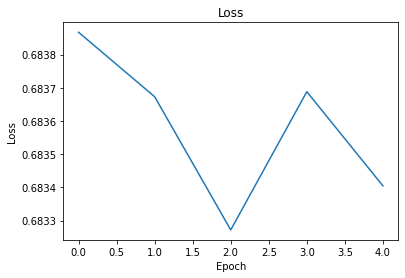

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
# plt.plot(test_losses)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

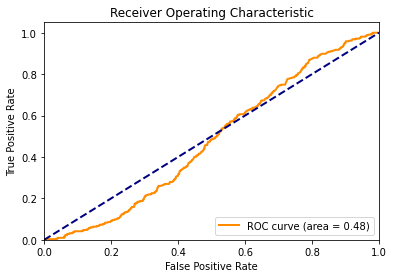

In [28]:
trainer.plot_roc_curve()

### Fine grained classification using Bilinear CNN

In [33]:
class BCNN(nn.Module):
    def __init__(self, num_classes):
        super(BCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
model = BCNN(num_classes).to(device)

In [35]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [36]:
num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.6868
Epoch 2/20, Loss: 0.6734
Epoch 3/20, Loss: 0.5700
Epoch 4/20, Loss: 0.5415
Epoch 5/20, Loss: 0.5229
Epoch 6/20, Loss: 0.5111
Epoch 7/20, Loss: 0.4998
Epoch 8/20, Loss: 0.4801
Epoch 9/20, Loss: 0.4747
Epoch 10/20, Loss: 0.4634
Epoch 11/20, Loss: 0.4647
Epoch 12/20, Loss: 0.4496
Epoch 13/20, Loss: 0.4416
Epoch 14/20, Loss: 0.4371
Epoch 15/20, Loss: 0.4205
Epoch 16/20, Loss: 0.4090
Epoch 17/20, Loss: 0.4078
Epoch 18/20, Loss: 0.3956
Epoch 19/20, Loss: 0.3843
Epoch 20/20, Loss: 0.3719


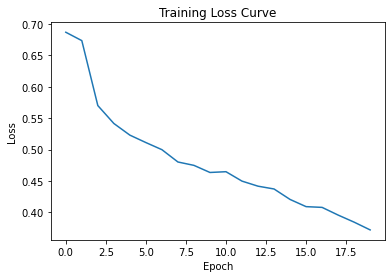

In [38]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [39]:
model.eval()
y_test_true = []
y_test_pred = []
y_test_score = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_test_true.extend(labels.cpu().numpy())
        y_test_pred.extend(predicted.cpu().numpy())
        y_test_score.extend(probabilities[:, 1].cpu().numpy())

accuracy = correct / total
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 80.20%


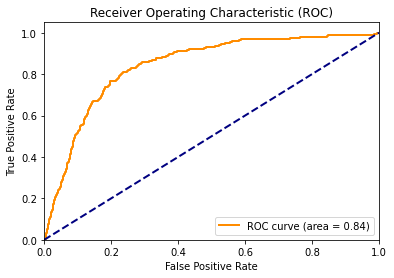

In [40]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()